In [0]:
%restart_python 


===== XGBoost Model Accuracy =====
RMSE : 3.53
MAE  : 2.43
MAPE : 9.09%


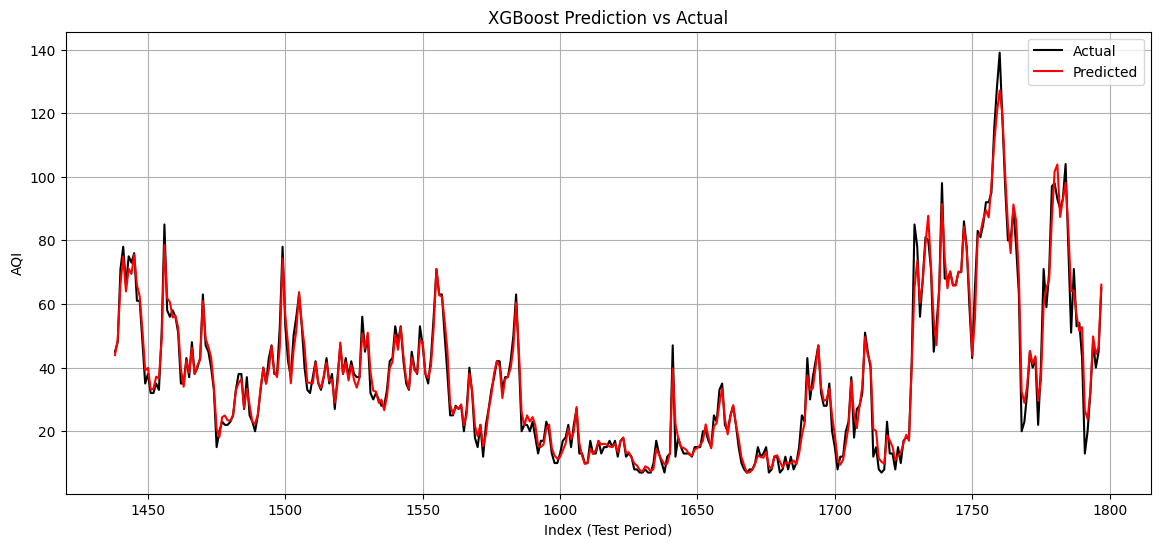

[66.08156]


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# -----------------------------------------
# 1. LOAD DATA
# -----------------------------------------
# df = pd.read_csv("your_file.csv")
df_spark = spark.read.table("aqi_cat.silver_schema.hyderabad_aqi_dataset").select("date","aqi_pm25")
# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
df= df_spark.toPandas()

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Choose target
target = "aqi_pm25"   # or "pm25"

# -----------------------------------------
# 2. FEATURE ENGINEERING
# -----------------------------------------

# Create lag features (AQI/PM2.5 from previous days)
df['lag1']  = df[target].shift(1)
df['lag2']  = df[target].shift(2)
df['lag7']  = df[target].shift(7)
df['lag14'] = df[target].shift(14)

# Rolling mean features
df['roll3']  = df[target].rolling(3).mean()
df['roll7']  = df[target].rolling(7).mean()
df['roll30'] = df[target].rolling(30).mean()

# Date features
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofweek'] = df['date'].dt.dayofweek

# Drop rows with NaN (from lags)
df2 = df.dropna().reset_index(drop=True)

# -----------------------------------------
# 3. TRAIN-TEST SPLIT
# -----------------------------------------
X = df2.drop([target, 'date'], axis=1)
y = df2[target]

# 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# -----------------------------------------
# 4. TRAIN XGBOOST MODEL
# -----------------------------------------
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

model.fit(X_train, y_train)

# -----------------------------------------
# 5. PREDICT
# -----------------------------------------
y_pred = model.predict(X_test)

# -----------------------------------------
# 6. ACCURACY METRICS
# -----------------------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n===== XGBoost Model Accuracy =====")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")

# -----------------------------------------
# 7. PLOT RESULTS
# -----------------------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label="Actual", color='black')
plt.plot(y_test.index, y_pred, label="Predicted", color='red')

plt.title("XGBoost Prediction vs Actual")
plt.xlabel("Index (Test Period)")
plt.ylabel("AQI" if target=="aqi_pm25" else "PM2.5")
plt.legend()
plt.grid(True)
plt.show()

last_row = X_test.tail(1).copy()
future_preds = model.predict(last_row)


# for i in range(30):  # next 30 days
#     next_pred = model.predict(last_row)[0]
#     future_preds.append(next_pred)
#     # update lags + rolling windows with this new prediction
#     # (I will generate full code if you want 7/30/60-day forecasting)

print(future_preds)
